# Predictive Modeling

## Modeling Objectives

This notebook builds and evaluates predictive models to understand which intake-related characteristics are associated with cat adoption and adoption speed. The goals are to:
- Predict the likelihood of adoption using only information available at intake
- Compare an interpretable baseline model to a more flexible tree-based model
- Assess the limits of predicting length of stay (LOS) using intake-related features
- Translate model outputs into operationally useful insights

This analysis prioritizes interpretability and robustness over marginal performance gains.

## Modeling Setup & Data Constraints

All models are trained using only intake-related features to avoid outcome leakage. Variables derived from outcomes or post-intake events are excluded from feature construction and model fitting.

A time-based train/test split is used to reflect real-world deployment, where models are trained on historical data and applied to future intakes.

## Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from pathlib import Path

parent_dir = str(Path().resolve().parent)
sys.path.append(parent_dir)

df = pd.read_csv("../data/processed/aac_processed.csv", parse_dates=["datetime_intake"])

## Build Features and Label

In [2]:
from src.features import validate_feature_inputs, build_intake_features, build_targets

validate_feature_inputs(df)
X_all = build_intake_features(df)
y = build_targets(df)

# align features with labeled outcomes
X_all = X_all.loc[y.index]

print(X_all.shape, y.shape)

(68591, 8) (68591,)


## Train / Test Split

The two labels, Adopted (y = 1) and Not Adopted (y = 0), are reasonably balanced in the dataset. Therefore, stratification is not required for model stability.

In [3]:
print(f"Distribution of adoption outcome:\nAdopted: {(y==1).mean():.2%} \nNot adopted: {(y==0).mean():.2%}")

Distribution of adoption outcome:
Adopted: 51.67% 
Not adopted: 48.33%


A time-based split is used to divide the data chronologically, using earlier intakes for training and later intakes for testing. This approach prevents information leakage from future intakes and more closely reflects a real-world prediction setting.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_all,
    y,
    test_size=0.2,
    random_state=2026,
    shuffle=False # no shuffling -- time-based split
)

## Feature Sets by Model Type

Two input variables contain age at intake at different levels of granularity: `age_intake_months` and `age_group_at_intake`. To avoid redundancy and improve interpretability, the baseline logistic regression model uses `age_group_at_intake` and the more flexible tree-based model uses `age_intake_months`. Those two variables are not used within the same model.

The categorical variables `intake_condition`, `breed_intake`, and `color_intake` contain rare levels that appear highly predictive due to very small sample sizes, as observed in `01_exploratory_data_analysis.ipynb`. For modeling and interpretation, rare levels are grouped to reduce variance and avoid overfitting.

In [5]:
X_all.head()

,age_intake_months,age_group_at_intake,intake_type,intake_condition,breed_intake,color_intake,has_name,intake_month
0,0.233333,kitten,Stray,Normal,Domestic Shorthair Mix,Orange/White,0,10
1,0.233333,kitten,Stray,Normal,Domestic Shorthair Mix,Orange/White,0,10
2,0.233333,kitten,Stray,Normal,Domestic Shorthair Mix,Orange/White,0,10
3,4.000000,kitten,Stray,Normal,American Shorthair Mix,Black/White,0,10
4,204.000000,senior,Owner Surrender,Normal,Domestic Shorthair Mix,Brown Tabby/White,1,10


## Logistic Regression (Interpretable Baseline)

### Feature Selection & Transformation

This baseline model uses `age_group_at_intake`, a less granular but more easily interpretable age-related feature, to support clear coefficient interpretation.

In [6]:
categorical_cols_lr = [
    "age_group_at_intake",
    "intake_type",
    "intake_condition",
    "breed_intake",
    "color_intake"
]
numeric_cols_lr = []
binary_cols_lr = ["has_name"]
features_lr = categorical_cols_lr + binary_cols_lr

from src.modeling import preprocess_features
preprocessor_lr = preprocess_features(categorical_cols_lr, numeric_cols_lr, binary_cols_lr)

### Model Training

In [7]:
from src.modeling import train_logistic_regression

log_reg = train_logistic_regression(
    preprocessor_lr, 
    X_train[features_lr], 
    y_train, 
    max_iter=1000,
    solver="liblinear",
    l1_ratio=0
)

### Model Evaluation

- The baseline model shows solid predictive performance (ROC-AUC = 0.7886).
- The model correctly classifies 72% of adoption outcomes on new data (test accuracy = 0.72).
- The model is conservative in predicting adoptions: 81% of predicted adoptions are correct (precision = 0.81), and 72% of actual adoptions are identified (recall = 0.72).

ROC-AUC: 0.7889
              precision    recall  f1-score   support

           0       0.60      0.72      0.66      5066
           1       0.81      0.72      0.77      8653

    accuracy                           0.72     13719
   macro avg       0.71      0.72      0.71     13719
weighted avg       0.74      0.72      0.73     13719



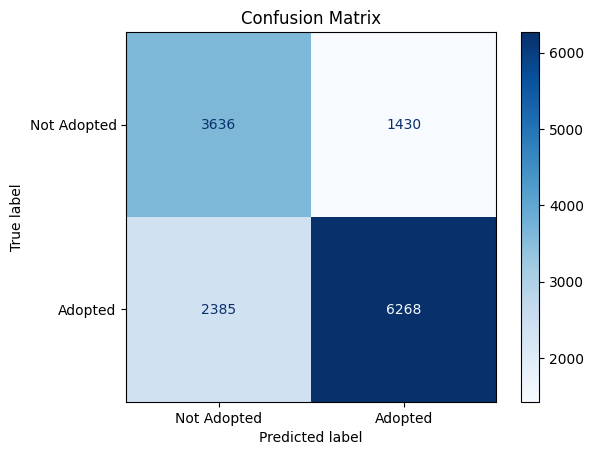

In [8]:
from src.modeling import evaluate_classifier

evaluate_classifier(log_reg, X_test[features_lr], y_test)

## Tree-Based Model (Flexible Model)

### Feature Selection & Transformation

This model uses `age_intake_months`, the more granular, numeric age-related feature.

In [9]:
categorical_cols_tree = [
    "intake_type",
    "intake_condition",
    "breed_intake",
    "color_intake"
]
numeric_cols_tree = [
    "age_intake_months"
]
binary_cols_tree = ["has_name"]

features_tree = categorical_cols_tree + numeric_cols_tree + binary_cols_tree
preprocessor_tree = preprocess_features(categorical_cols_tree, numeric_cols_tree, binary_cols_tree)

### Model Training

In [10]:
from src.modeling import train_xgb_classifier

xgb = train_xgb_classifier(
        preprocessor_tree, 
        X_train[features_tree], 
        y_train,
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        eval_metric="logloss",
        random_state=2026
)

### Evaluation & Comparison

- The tree-based model shows strong predictive performance (ROC-AUC = 0.8388).
- The model correctly classifies 77% of adoption outcomes in new data (test accuracy = 0.77).
- Predictions are well balanced: 82% of predicted adoptions are correct (precision = 0.82), and 81% of actual adoptions are successfully identified (recall = 0.81).

ROC-AUC: 0.8388
              precision    recall  f1-score   support

           0       0.69      0.70      0.69      5066
           1       0.82      0.81      0.82      8653

    accuracy                           0.77     13719
   macro avg       0.75      0.75      0.75     13719
weighted avg       0.77      0.77      0.77     13719



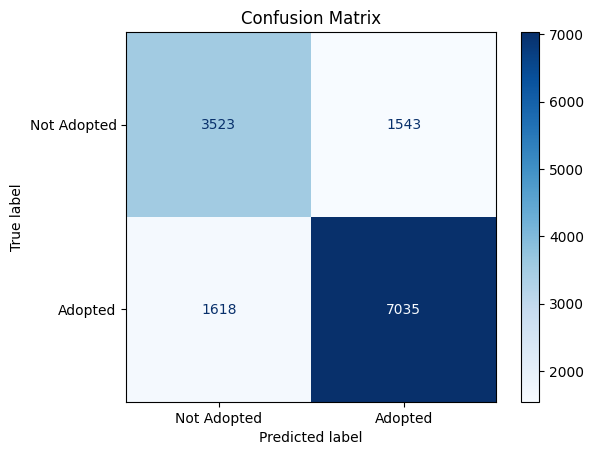

In [11]:
evaluate_classifier(xgb, X_test[features_tree], y_test)

### Model Tradeoffs:

The baseline logistic regression model is more interpretable and computationally efficient. It provides adequate predictive performance and makes conservative adoption predictions.

The tree-based model achieves higher predictive accuracy and produces more balanced predictions but is less interpretable and more computationally expensive.

**Recommendations**:
- Use the baseline model when interpretability and simplicity are prioritized and moderate performance is acceptable.
- Use the tree-based model when higher accuracy is required, particularly to identify as many adoptable cats as possible with confidence.

## Feature Importance

### Logistic Regression Coefficients

Intake condition, breed and color contain many rare categories, some of which appear highly predictive due to very small sample sizes. To avoid overinterpreting these rare levels, coefficient magnitudes are aggregated at the feature-group level.

**In the baseline model, color appears to contribute the most to adoption prediction overall, followed by intake condition**. Individual color- and condition-level coefficients are not interpreted in isolation.

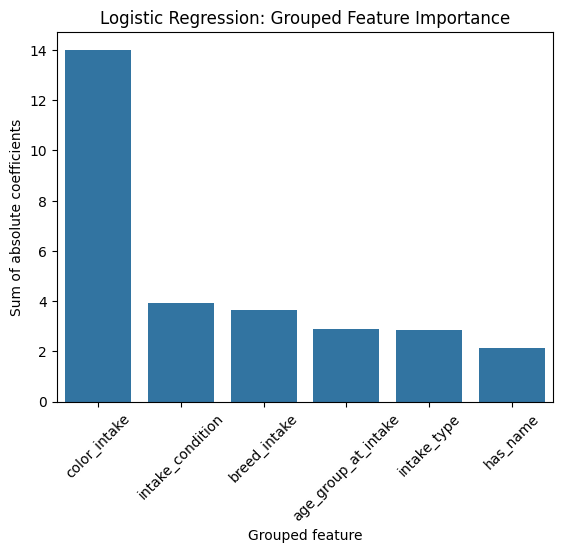

In [12]:
from src.modeling import feature_importance_logistic

group_importance = feature_importance_logistic(log_reg, features_lr)

sns.barplot(group_importance)
plt.title("Logistic Regression: Grouped Feature Importance")
plt.xlabel("Grouped feature")
plt.ylabel("Sum of absolute coefficients")
plt.xticks(rotation=45)
plt.show()

### Tree Feature Importance (SHAP)

**In the tree-based model, color and intake condition contribute the most to adoption prediction.** 

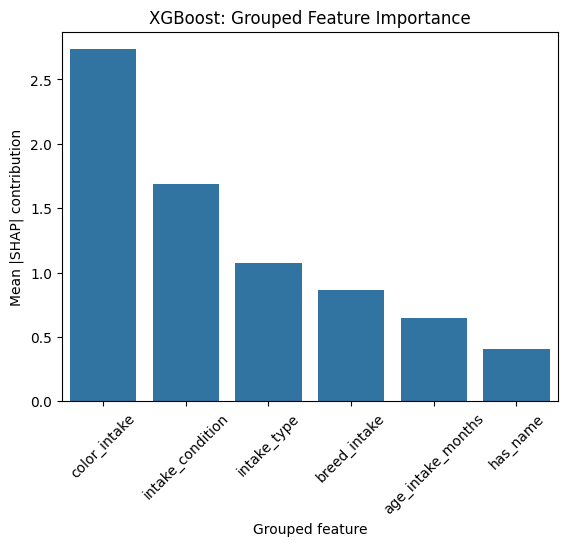

In [13]:
from src.modeling import feature_importance_shap

group_shap_importance = feature_importance_shap(xgb, X_test, features_tree)

sns.barplot(group_shap_importance)
plt.title("XGBoost: Grouped Feature Importance")
plt.xlabel("Grouped feature")
plt.ylabel("Mean |SHAP| contribution")
plt.xticks(rotation=45)
plt.show()

## Length of Stay (LOS) (Conditional Analysis)

Length of stay is modeled only among intakes that lead to adoptions, to avoid censoring bias.

In [14]:
adopted = df[df["is_adopted"]].copy()

# build features and response
X_los = build_intake_features(adopted)
y_los = np.log1p(adopted["length_of_stay_days"])
X_los = X_los.loc[y_los.index]

print(X_los.shape, y_los.shape)

(35444, 8) (35444,)


In [15]:
# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X_los,
    y_los,
    test_size=0.2,
    random_state=2026,
    shuffle=False # no shuffling -- time-based split
)

In [16]:
# preprocess features
categorical_cols_los = [
    "intake_type",
    "intake_condition",
    "intake_month",
    "breed_intake",
    "color_intake"
]
numeric_cols_los = [
    "age_intake_months"
]
binary_cols_los = ["has_name"]

features_los = categorical_cols_los + numeric_cols_los + binary_cols_los
preprocessor_los = preprocess_features(categorical_cols_los, numeric_cols_los, binary_cols_los)

In [17]:
from src.modeling import train_xgb_regressor

# train XGBoost model
xgb = train_xgb_regressor(
        preprocessor_los, 
        X_train[features_los], 
        y_train,
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        eval_metric="rmse",
        random_state=2026
)

### Evaluation

The LOS prediction model shows limited performance (R-squared = 0.3871). This means intake-related variables explain some, but not most, of LOS variation. Many drivers of LOS occur after post-intake, such as behavioral assessment and marketing exposure.

In [18]:
from src.modeling import evaluate_regressor

# evaluate XGBoost model
evaluate_regressor(xgb, X_test[features_los], y_test)

R-squared: 0.3871
Mean squared error: 0.6943
Root mean squared error: 0.8333


### Feature Importance

**Color at intake appears to be the most meaningful predictor of LOS.**

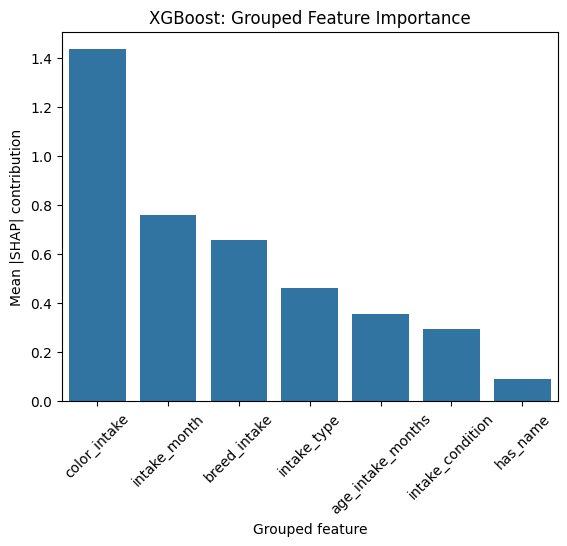

In [19]:
# calculate and visualize grouped feature importance
group_shap_importance = feature_importance_shap(xgb, X_test, features_los)

sns.barplot(group_shap_importance)
plt.title("XGBoost: Grouped Feature Importance")
plt.xlabel("Grouped feature")
plt.ylabel("Mean |SHAP| contribution")
plt.xticks(rotation=45)
plt.show()

## Conclusions

This analysis shows that cat adoption outcomes can be predicted with meaningful accuracy using only intake-related information. Color, intake condition, intake type, breed, age at intake, name presence, and intake timing all contribute to adoption likelihood.

An interpretable logistic regression model provides a strong baseline with conservative predictions and clear coefficient interpretation, making it suitable for communication and operational decision-making. A more flexible tree-based model improves predictive accuracy and recall, offering better performance when identifying adoptable cats is a priority.

In contrast, predicting length of stay using intake-related variables alone remains challenging. While age at intake is informative, much of the variation in LOS is driven by post-intake factors not observable at the time of entry.

Overall, this analysis highlights both what intake-related data can explain and where it falls short, providing practical guidance for decision making and future model refinement.